<a href="https://colab.research.google.com/github/nooshy1/OSRS/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-25-1688742686>:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_history[name] = df['avgHighPrice'].replace(0, np.nan).fillna(method='ffill')
<ipython-input-25-1688742686>:91: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  "volatility": np.std(df['avgHighPrice'].replace(0, np.nan).fillna(method='ffill').pct_change().dropna()),
<ipython-input-25-1688742686>:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_history[name] = df['avgHighPrice'].replace(0, np.nan).fillna(method='ffill')
<ipython-input-25-1688742686>:91: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  "volatility": np.std(df['avgHighPrice'].replace(0, n


🌟 OSRS Watchlist - Anomalous Items:
       id                name     price       low  spread
2   11806  Saradomin godsword  38580043  38580043       0
13  11828  Armadyl chestplate  50000000  50001001   -1001
14  11830  Armadyl chainskirt  38359598  37446881  912717
24  12936        Jar of swamp     98000     92400    5600
28  13267  Abyssal dagger (p)   2120000   1860001  259999


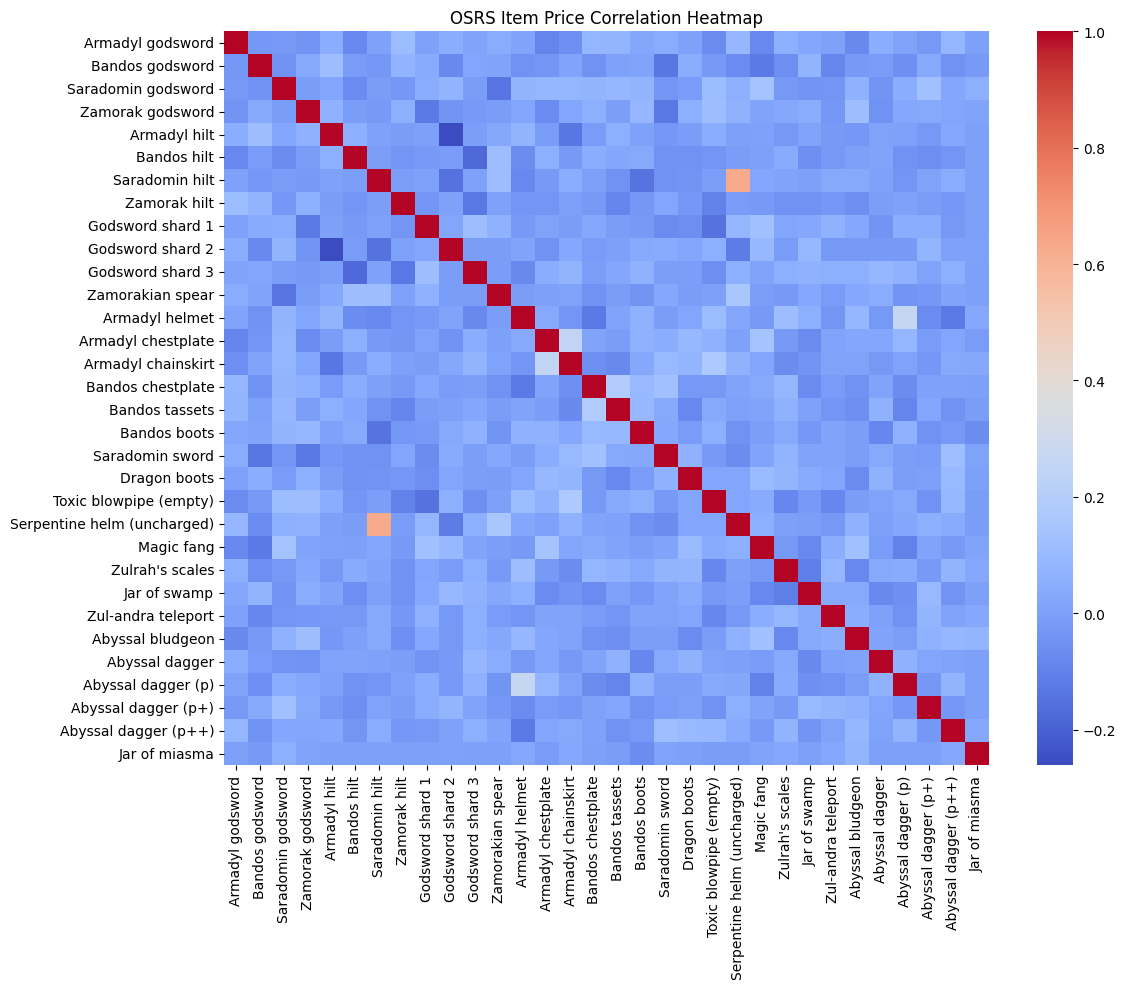

<ipython-input-25-1688742686>:128: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  reduced = pca.fit_transform(price_matrix.fillna(method='ffill').pct_change().dropna().T)


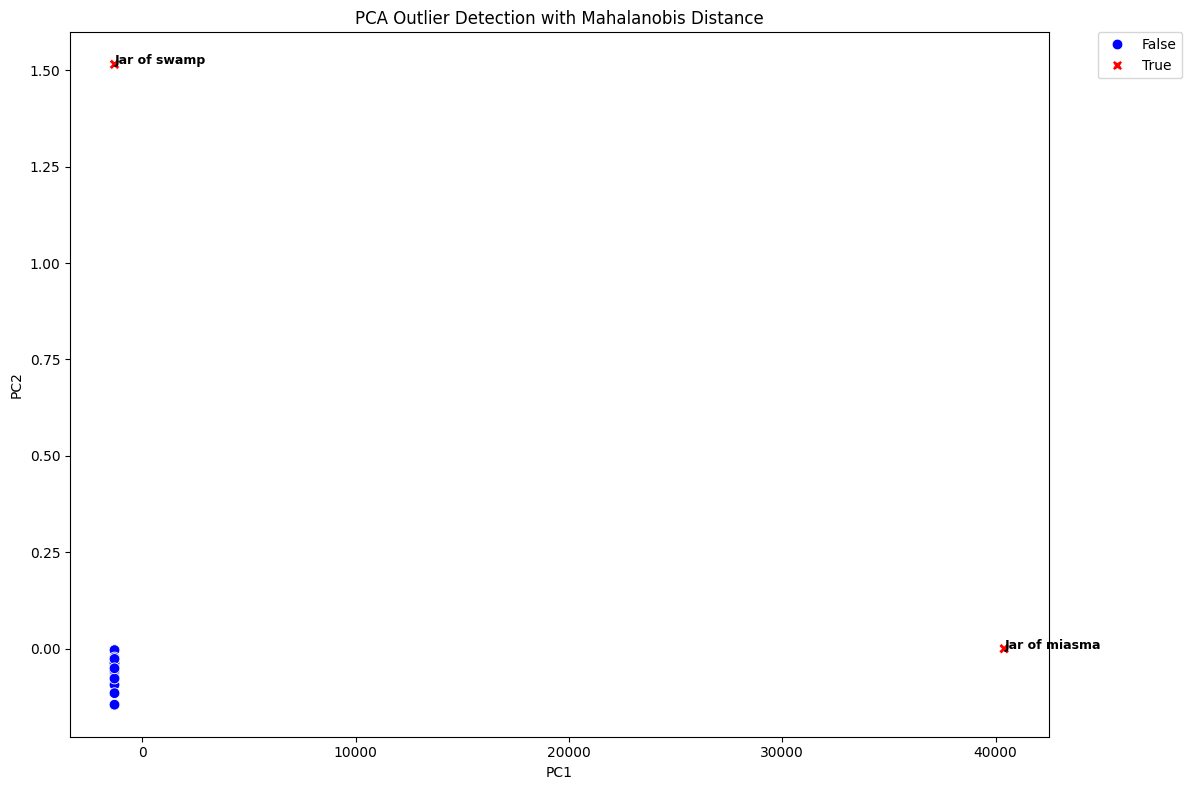

In [25]:
# OSRS Quant Watchlist + Correlation Model (OSRS Wiki API Version)

# 📦 Step 1: Install required packages (Colab will need these)
!pip install requests pandas scikit-learn matplotlib seaborn

# 📚 Step 2: Import libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from scipy.spatial import distance
import time

# 🔁 Step 3: Define function to fetch item prices from OSRS Wiki API

WIKI_API = "https://prices.runescape.wiki/api/v1/osrs"

HEADERS = {
    "User-Agent": "OSRS-Quant-Tool/1.0 (contact: example@email.com)"
}

def fetch_latest_prices():
    url = f"{WIKI_API}/latest"
    response = requests.get(url, headers=HEADERS)
    if response.status_code == 200:
        return response.json().get("data", {})
    else:
        print(f"Latest price fetch failed: {response.status_code}")
        return {}

def fetch_timeseries(item_id):
    url = f"{WIKI_API}/timeseries?timestep=1h&id={item_id}"
    response = requests.get(url, headers=HEADERS)
    if response.status_code == 200:
        return response.json().get("data", [])
    else:
        print(f"Graph fetch failed for {item_id}: {response.status_code}")
        return []

def fetch_item_mapping():
    url = "https://prices.runescape.wiki/api/v1/osrs/mapping"
    response = requests.get(url, headers=HEADERS)
    if response.status_code == 200:
        return {item['id']: item['name'] for item in response.json()}
    else:
        print("Item mapping fetch failed")
        return {}

# 🎯 Step 4: Define PvM item IDs (must be valid OSRS Wiki IDs)
item_ids = [
    11802, 11804, 11806, 11808, 11810, 11812, 11814, 11816, 11818, 11820,
    11822, 11824, 11826, 11828, 11830, 11832, 11834, 11836, 11838, 11840,
    11842, 11844, 11846, 11848, 11850, 11852, 11854, 11856, 11858, 11860,
    12924, 12929, 12931, 12932, 12934, 12936, 12938, 12940, 12954, 13262,
    13263, 13265, 13267, 13269, 13271, 13275, 13277, 13279, 13281, 13283,
    13285, 13287, 13289, 13291, 13293, 13295, 13297, 13299, 13301, 13303
]

latest_prices = fetch_latest_prices()
item_name_map = fetch_item_mapping()

items = []
price_history = {}

for item_id in item_ids:
    price_data = latest_prices.get(str(item_id))
    if not price_data:
        continue

    timeseries = fetch_timeseries(item_id)
    if not timeseries:
        continue

    name = item_name_map.get(item_id, f"Item {item_id}")
    df = pd.DataFrame(timeseries)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df.set_index('timestamp', inplace=True)
    price_history[name] = df['avgHighPrice'].replace(0, np.nan).fillna(method='ffill')

    items.append({
        "id": item_id,
        "name": name,
        "price": price_data.get("high", 0),
        "low": price_data.get("low", 0),
        "spread": price_data.get("high", 0) - price_data.get("low", 0),
        "volatility": np.std(df['avgHighPrice'].replace(0, np.nan).fillna(method='ffill').pct_change().dropna()),
        "momentum": df['avgHighPrice'].iloc[-1] - df['avgHighPrice'].iloc[0]
    })

# 📊 Step 5: DataFrame & Modeling

df = pd.DataFrame(items)
features = ['spread', 'volatility', 'momentum']

# Clean and drop rows with NaNs in feature columns
df_clean = df.dropna(subset=features).copy()
X = StandardScaler().fit_transform(df_clean[features])

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(X)

# Isolation Forest for anomaly detection
iso = IsolationForest(contamination=0.2, random_state=42)
df_clean['anomaly'] = iso.fit_predict(X)
df_clean['anomaly'] = df_clean['anomaly'].map({1: 'normal', -1: 'anomaly'})

print("\n🌟 OSRS Watchlist - Anomalous Items:")
print(df_clean[df_clean['anomaly'] == 'anomaly'][['id', 'name', 'price', 'low', 'spread']])

# 🔹 Step 6: Correlation Analysis
price_matrix = pd.concat(price_history.values(), axis=1)
price_matrix.columns = list(price_history.keys())
correlation_matrix = price_matrix.pct_change().corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', xticklabels=True, yticklabels=True)
plt.title("OSRS Item Price Correlation Heatmap")
plt.tight_layout()
plt.show()

# 📀 Step 7: PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(price_matrix.fillna(method='ffill').pct_change().dropna().T)
pca_df = pd.DataFrame(reduced, columns=['PC1', 'PC2'])
pca_df['Item'] = list(price_history.keys())

# Mahalanobis distance calculation
mean_vec = np.mean(reduced, axis=0)
cov_matrix = np.cov(reduced.T)
cov_inv = np.linalg.inv(cov_matrix)
mahal_distances = [distance.mahalanobis(row, mean_vec, cov_inv) for row in reduced]
pca_df['Mahalanobis'] = mahal_distances
threshold = np.percentile(mahal_distances, 95)
pca_df['Outlier'] = pca_df['Mahalanobis'] > threshold

plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue='Outlier', style='Outlier', palette={True: 'red', False: 'blue'}, s=60)
for i, row in pca_df.iterrows():
    if row['Outlier']:
        ax.text(row['PC1'], row['PC2'], row['Item'], fontsize=9, weight='bold')
plt.title("PCA Outlier Detection with Mahalanobis Distance")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()
